<h1>NetworkX Demo</h1>

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys
basedir = '../'
sys.path.append(basedir)

import numpy as np
import pandas as pd
import networkx as nx
import pylab as plt

import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib.colors import rgb2hex

from IPython.display import display
from lda_for_fragments import Ms2Lda
from visualisation.networkx.lda_visualisation import *

# get rid of annoying warnings
import warnings
warnings.filterwarnings('ignore')

<h2>1. Load Data and apply thresholding</h2>

Load Beer3pos project used by Justin and apply thresholding below.

In [2]:
ms2lda = Ms2Lda.resume_from('results/Manuscript_Beer3POSmode_EFassignerALL.project')

Project loaded from results/Manuscript_Beer3POSmode_EFassignerALL.project time taken = 20.4736540318
 - input_filenames = 
	../input/manuscript/Beer3pos_MS1filter_Method3_fragments.csv
	../input/manuscript/Beer3pos_MS1filter_Method3_losses.csv
	../input/manuscript/Beer3pos_MS1filter_Method3_ms1.csv
	../input/manuscript/Beer3pos_MS1filter_Method3_ms2.csv
 - df.shape = (1422, 4496)
 - K = 300
 - alpha = 0.166666666667
 - beta = 0.1
 - number of samples stored = 1
 - last_saved_timestamp = 11/11/15 23:39:09
 - message = Beer3Pos analysis for the manuscript with EFassigner EF assignments for ms1, fragments, and losses


In [3]:
ms2lda.do_thresholding(th_doc_topic=0.05, th_topic_word=0.01)

<h2>2. Create network graph</h2>

Specify the list of motifs of interest below. 

In [4]:
# all the highest-confidence motifs
# motifs_of_interest = [260, 262, 226, 158, 243, 127, 174, 59, 
#                       214, 60, 151, 40, 284, 276, 45, 79, 184, 
#                       130, 220, 55, 241, 13, 115, 162, 19, 58, 
#                       202, 131, 129, 222, 230, 67, 42, 116]

# smaller list
motifs_of_interest = [262, 158, 220, 55, 241, 115, 202, 226, 22, 58, 19]

In [5]:
G = get_network_graph(ms2lda, motifs_of_interest)
print "\n" + nx.info(G)

Removed 289 motifs from the graph because they're not in the list
Removed ['motif_22'] from the graph because they don't share documents with other motifs in the list
Removed 1099 unconnected documents from the graph

Name: 
Type: Graph
Number of nodes: 333
Number of edges: 357
Average degree:   2.1441


So, when we create the graph *G*, we also filtered it in such a way that (1) only the motifs in the provided list are retained and additionally, (2) these motifs must have some documents shared with another motif.

Next, we draw a bipartite graph where the left side is the MS1 peaks (labelled by their peak ids) and the right side are the M2Ms. The graph has been filtered such that we only show MS1 peaks that are connected to at least *min_degree* number of Mass2Motifs. 

The number beside each motif (e.g. +25) shows how many other MS1 connected to it that we are not showing because there's no overlap with other motifs in the list.

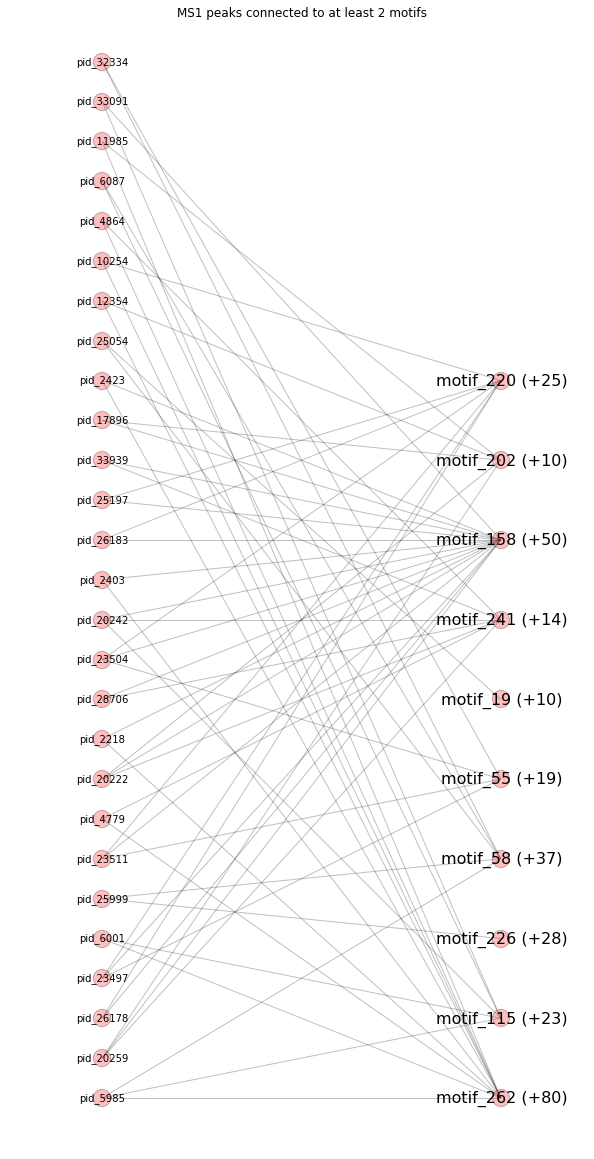

In [6]:
doc_nodes, doc_motifs, motif_idx = plot_bipartite(G, min_degree=2, fig_width=10, fig_height=20, spacing_left=1, spacing_right=2)

# can tweak the fig_ and spacing_ parameters to adjust the plot appearance, especially if graph is dense
# doc_nodes, doc_motifs, motif_idx = plot_bipartite(G, min_degree=3, fig_width=10, fig_height=20, spacing_left=1, spacing_right=2)

We can also plot the fragmentation spectra of these MS1 peaks of interest, coloring their MS2 peaks by the motifs. First, we set up some objects that would be used later.

In [7]:
# find out which words belong to which M2M
word_map = ms2lda.print_motif_features(selected_motifs=motifs_of_interest, quiet=True)

# read CSV annotation
motif_annotation = {}
for item in csv.reader(open("results/beer3pos_annotation.csv"), skipinitialspace=True):
    key = int(item[0])
    val = item[1]
    motif_annotation[key] = val
    
# map each motif to the colourmap too
# http://matplotlib.org/1.2.1/mpl_examples/pylab_examples/show_colormaps.hires.png
norm = mpl.colors.Normalize(vmin=min(motif_idx.values()), vmax=max(motif_idx.values()))
cmap = cm.gist_rainbow
motif_colour = cm.ScalarMappable(norm=norm, cmap=cmap)

<h2>4. Example</h2>

The following function plots a network graph in the same manner as in LDAVis. Depending on the data being plotted, we probably have to tweak the parameters below to get nice-looking figures. 

In [62]:
def plot_subgraph(G, m2m_list, ms1_peakids_to_highlight, motif_idx, colour_map, save_to=None):
    
    # parameters for the M2M nodes
    motif_node_alpha = 0.75
    motif_node_size = 2000
    
    # parameters for the ms1_peakids_to_highlight
    highlight_node_colour = 'gray'
    highlight_node_alpha = 0.75
    highlight_node_size = 600
    
    # parameters for other nodes
    other_nodes_colour = 'lightgray'
    other_nodes_alpha = 0.20
    other_nodes_size = 600

    # label parameters
    label_colour = 'black'
    label_background_colour = 'gray'
    label_alpha = 0.50
    label_fontsize = 16
    
    # other parameters
    fig_width = 15
    fig_height = 15
    edge_alpha = 0.25    
        
    highlight_docs = set()
    other_docs = set()
    motif_nodes = set()    
    motif_colours = []
    doc_labels = {}
    motif_labels = {}
    for node_id, node_data in G.nodes(data=True):
        
        # group == 1 is a doc, 2 is a motif
        if node_data['group'] == 1 and int(node_data['peakid']) in ms1_peakids_to_highlight:
            highlight_docs.add(node_id)
            doc_labels[node_id] = node_data['peakid']

        elif node_data['group'] == 2:
            motif_name = node_data['name']
            _, motif_id = motif_name.split('_')
            motif_id = int(motif_id)
            if motif_id in m2m_list:
                motif_nodes.add(node_id)
                neighbours = G.neighbors(node_id)
                other_docs.update(neighbours)
                node_colour = colour_map.to_rgba(motif_idx[motif_id])
                node_colour = rgb2hex(node_colour)
                motif_colours.append(node_colour)
                motif_labels[node_id] = 'M2M_%d' % motif_id

    other_docs = other_docs - highlight_docs
    to_keep = motif_nodes | highlight_docs | other_docs
    SG = nx.Graph(G.subgraph(to_keep))
    for u, v, d in SG.edges(data=True):
        d['weight'] *= 100

    plt.figure(figsize=(fig_width, fig_height), dpi=900)
    plt.axis('off')
    fig = plt.figure(1)
    
    pos = nx.spring_layout(SG, k=0.25, iterations=50)
    nx.draw_networkx_nodes(SG, pos, nodelist=other_docs, 
                           alpha=other_nodes_alpha, node_color=other_nodes_colour, 
                           node_size=other_nodes_size)
    nx.draw_networkx_nodes(SG, pos, nodelist=highlight_docs, 
                           alpha=highlight_node_alpha, node_color=highlight_node_colour, 
                           node_size=highlight_node_size)
    nx.draw_networkx_nodes(SG, pos, nodelist=motif_nodes, 
                           alpha=motif_node_alpha, node_color=motif_colours,
                           node_size=motif_node_size)
    nx.draw_networkx_edges(SG, pos, alpha=edge_alpha)    
    nx.draw_networkx_labels(SG, pos, doc_labels, font_size=10)
    nx.draw_networkx_labels(SG, pos, motif_labels, font_size=16)    
    
#     for node_id in node_labels:
#         x, y = pos[node_id]
#         label = node_labels[node_id]
#         y_offset = -0.3
#         if node_id in motif_nodes:
#             y_offset += -0.5
#         plt.text(x,y+y_offset, s=node_labels[node_id], 
#                  color=label_colour, fontsize=label_fontsize,
#                  bbox=dict(facecolor=label_background_colour, alpha=label_alpha), 
#                  horizontalalignment='center') 
        
    if save_to is not None:
        print "Figure saved to %s" % save_to
        plt.savefig(save_to, bbox_inches='tight')
    plt.show()        

Using motif 58 and 19 as suggested by Justin

In [15]:
# check their respective peak IDs and see if any overlap
peak_ids1 = get_peak_ids_of_m2m(G, 58)
peak_ids2 = get_peak_ids_of_m2m(G, 19)
overlap = peak_ids1.intersection(peak_ids2)

print peak_ids1
print
print peak_ids2
print
print overlap

set([33793, 4331, 2820, 2951, 31468, 23564, 25999, 34065, 2967, 4378, 14239, 4260, 6063, 1073, 25267, 4276, 33722, 16063, 16126, 4427, 18756, 6087, 26995, 34381, 1102, 33108, 32334, 31830, 34391, 2852, 16092, 1117, 25054, 5985, 4587, 33516, 31346, 25075, 4341, 1087, 7676, 25086])

set([33376, 18337, 9034, 9259, 9071, 23984, 33815, 30232, 33851, 24157, 25054])

set([25054])


 - M2M_58	: Phenylacetaldehyde substructure (benzene ring with ethanol group attached)
 - M2M_19	: Ferulic acid based substructure

Figure saved to results/example1_0.pdf


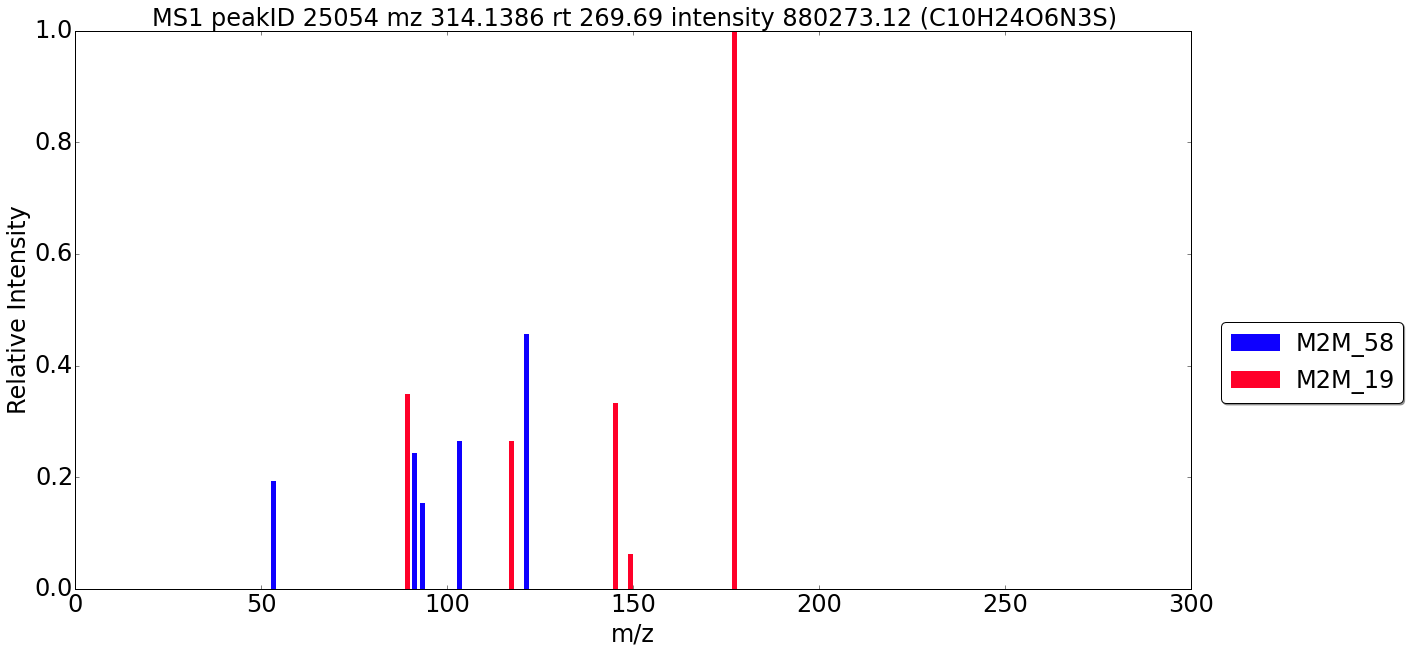

 - M2M_58	: Phenylacetaldehyde substructure (benzene ring with ethanol group attached)

Figure saved to results/example1_1.pdf


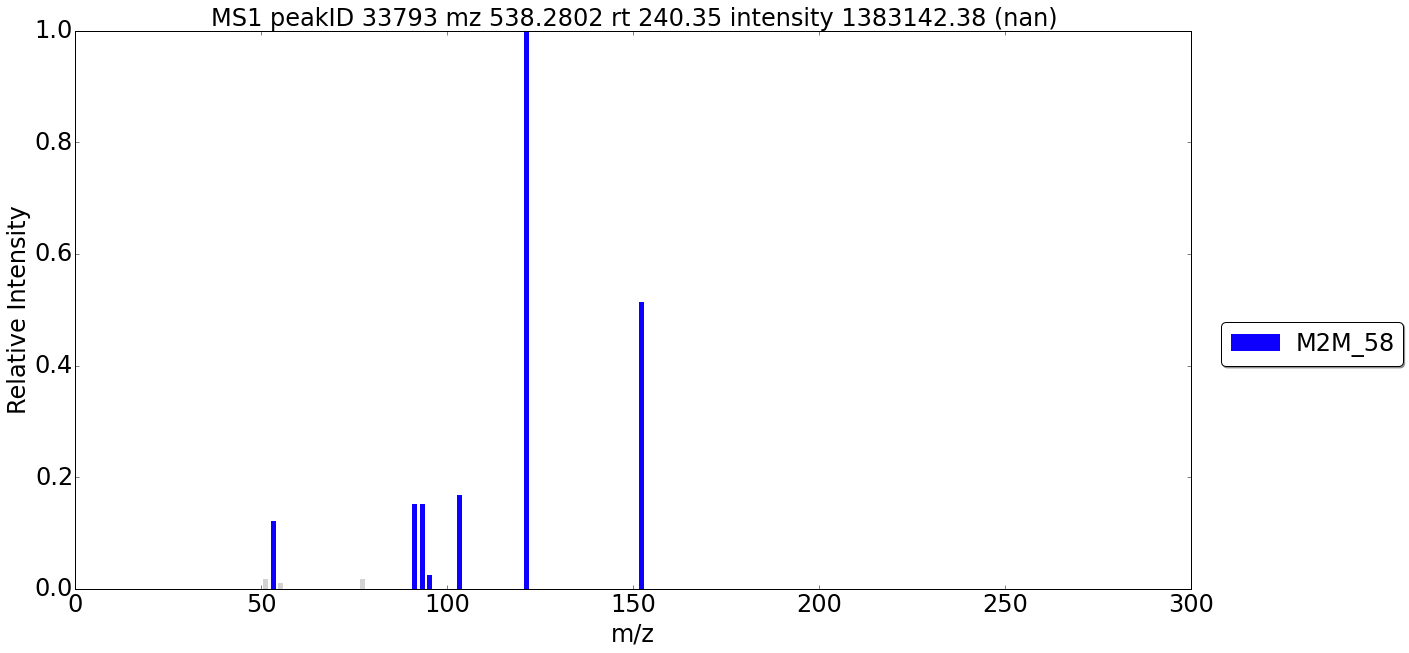

 - M2M_58	: Phenylacetaldehyde substructure (benzene ring with ethanol group attached)

Figure saved to results/example1_2.pdf


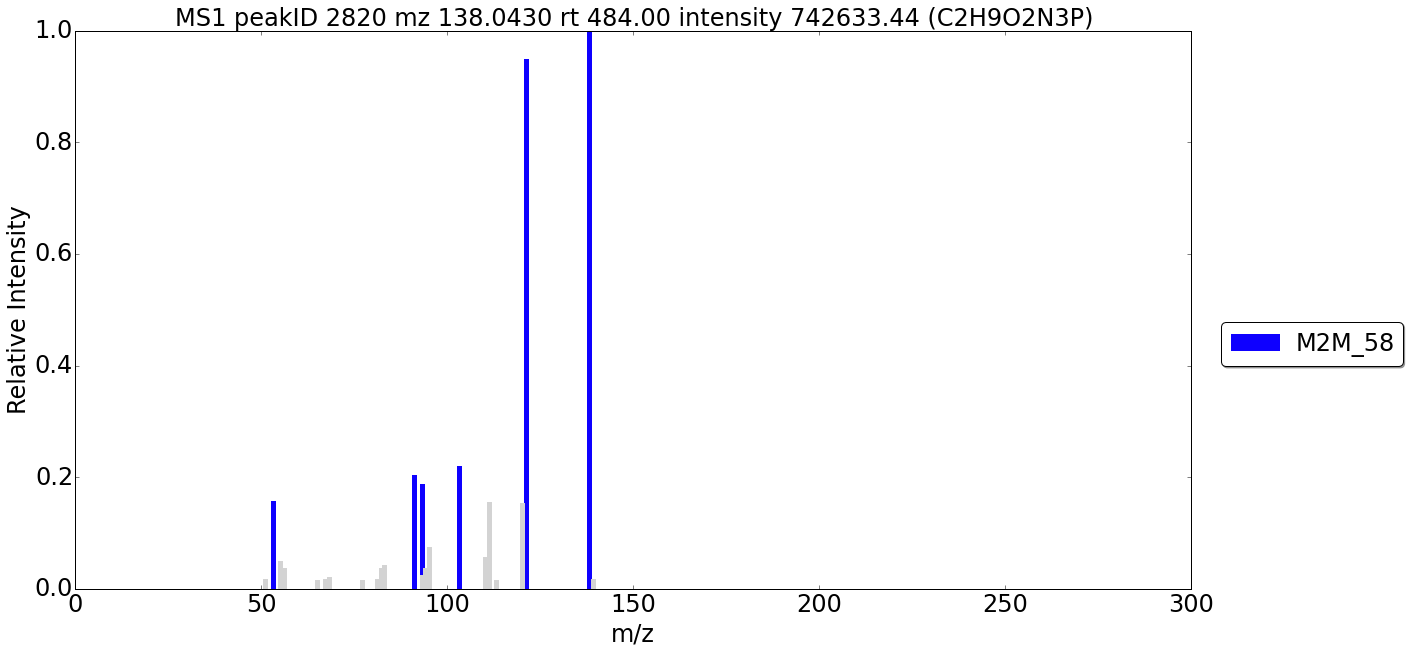

 - M2M_19	: Ferulic acid based substructure

Figure saved to results/example1_3.pdf


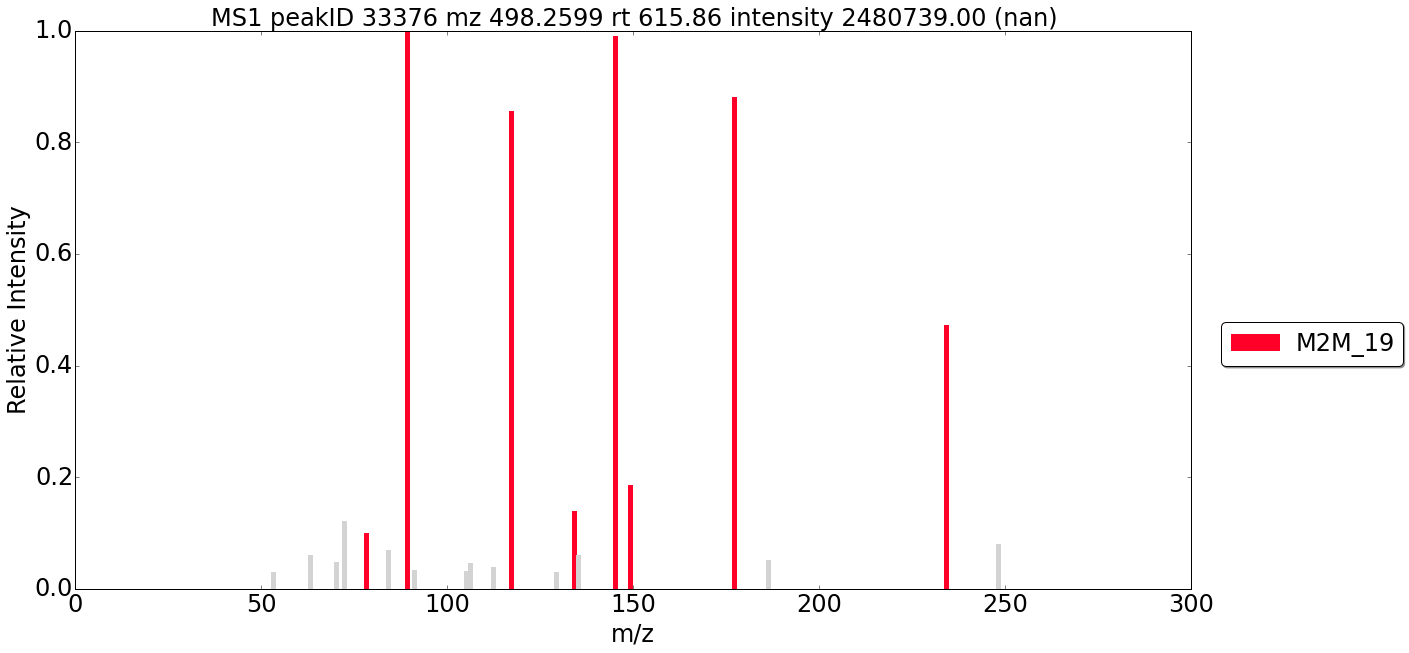

 - M2M_19	: Ferulic acid based substructure

Figure saved to results/example1_4.pdf


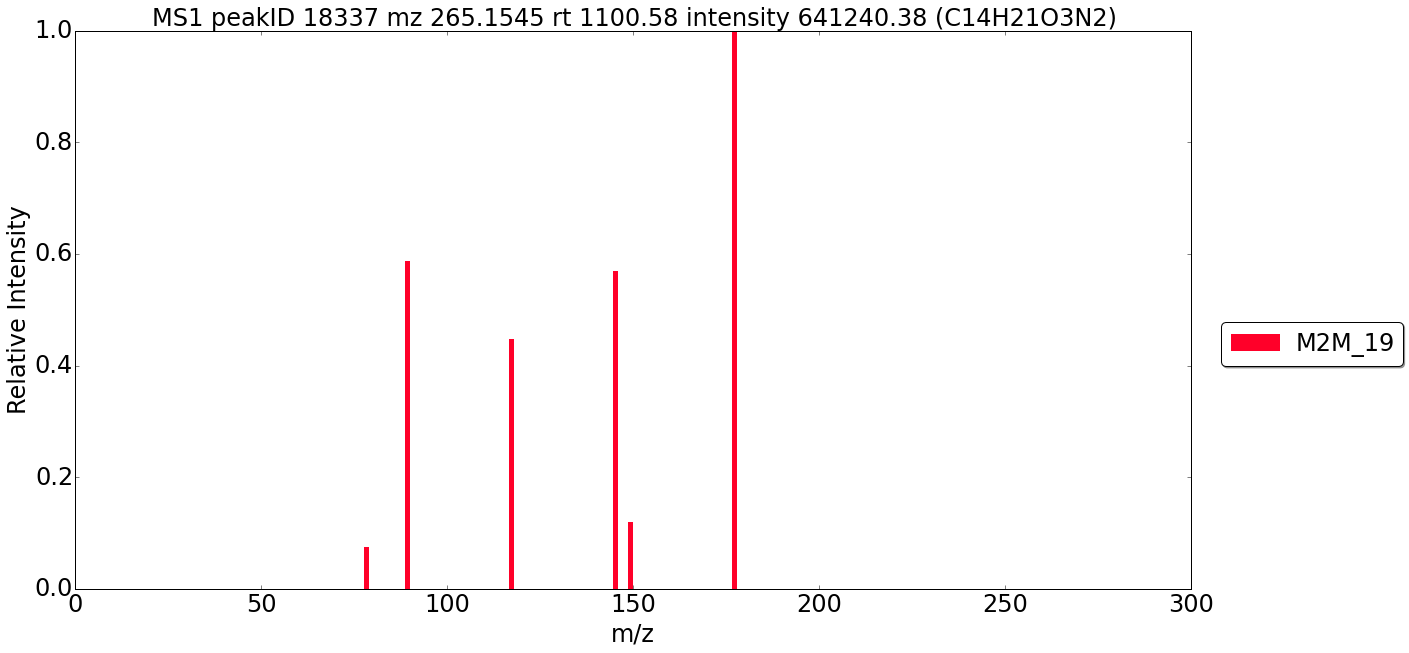

In [31]:
# print some fragmentation spectra
m2m_list = [58, 19]
ms1_list = [25054, 33793, 2820, 33376, 18337]

# loop over all ms1 in ms1_list
for i in range(len(ms1_list)):
    
    out_file = 'results/example1_%d.pdf' % i

    ms1 = ms1_list[i]
    df = print_report(ms2lda, G, ms1, motif_annotation, motif_colour, motif_idx, word_map, 
                      save_to=out_file, xlim_upper=300)
    # display(df) # show the table to see the mz, annotations, etc

Figure saved to results/example2.pdf


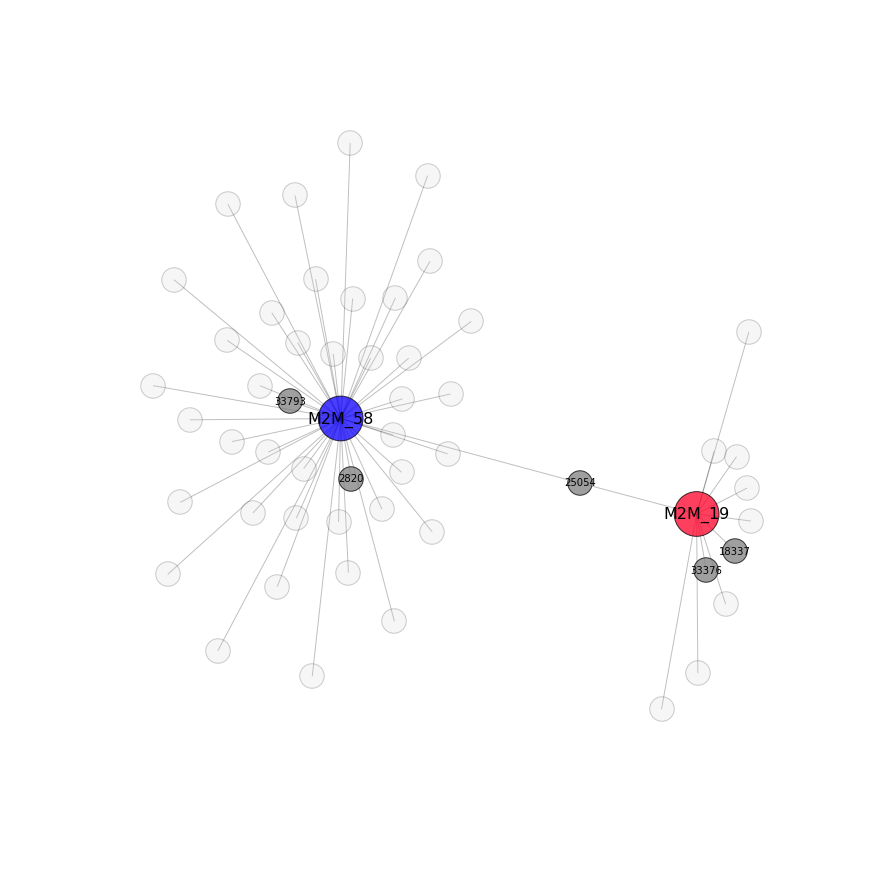

In [63]:
# plot the network for these nodes
plot_subgraph(G, m2m_list, ms1_list, motif_idx, motif_colour, save_to='results/example2.pdf')

<hr/>

<h2>6. Others</h2>

The following plots all the MS1 nodes of interest (degree > min_degree) in the bipartite graph

In [ ]:
# print all the nodes of interest in the bipartite graph
for node_id in doc_nodes:
    peak_id = int(G.node[node_id]['peakid'])    
    df = print_report(ms2lda, G, peak_id, motif_annotation, motif_colour, motif_idx, word_map)